In [1]:
from sqlalchemy import create_engine, text
import psycopg2
import psycopg2.extras
import json
import os
import pandas as pd
import plotly.express as px
import plotly.io as pio
pio.renderers.default = 'iframe'

credentials = "Credentials.json"

def pgconnect(credential_filepath, db_schema="public"):
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        host       = db_conn_dict['host']
        db_user    = db_conn_dict['user']
        db_pw      = db_conn_dict['password']
        default_db = db_conn_dict['user']
        port       = db_conn_dict['port']
        try:
            db = create_engine(f'postgresql+psycopg2://{db_user}:{db_pw}@{host}:{port}/{default_db}', echo=False)#, plugins=["geoalchemy2"])
            conn = db.connect()
            print('Connected successfully.')
        except Exception as e:
            print("Unable to connect to the database.")
            print(e)
            db, conn = None, None
        return db,conn

#edited to not need conn input
def query(sqlcmd, args=None, df=True):
    global conn
    result = pd.DataFrame() if df else None
    try:
        if df:
            result = pd.read_sql_query(sqlcmd, conn, params=args)
        else:
            result = conn.execute(text(sqlcmd), args).fetchall()
            result = result[0] if len(result) == 1 else result
    except Exception as e:
        print("Error encountered: ", e, sep='\n')
    return result

#can call this instead of having to redo everything when connection breaks
def reset():
    global db, conn
    db, conn = pgconnect(credentials)
    conn.execute(text("CREATE EXTENSION IF NOT EXISTS postgis;"))
    conn.commit()
    conn.execute(text("CREATE SCHEMA IF NOT EXISTS sa2; SET search_path TO sa2, public;"))
    conn.commit()

reset()

Connected successfully.


In [42]:
#Geopandas imports
#%matplotlib inline

from __future__ import (absolute_import, division, print_function)
import os

import matplotlib as mpl
import matplotlib.pyplot as plt

import geoalchemy2

from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
mpl.__version__, pd.__version__, gpd.__version__

('3.10.0', '2.2.3', '1.0.1')

In [3]:
#%matplotlib inline

# Understanding and Ingesting the Data


# Income.csv
    Total earnings statistics by SA2 (for later correlation analysis).
    First 2 columns all filled, rest are sometimes filled with 'np'---needs filtering
#### sa2_code21
    9-digit integer primary key
#### sa2_name
    Varchar name of region
#### earners
    Number of people earning money in this sa2 region
#### median_age
    Not clear. Either median population age or median earner age
#### median_income
    Median income of sa2 area
#### mean_income
    Mean income of sa2 area

In [4]:
#read in data
income_data = pd.read_csv('Income.csv')
#rename sa2_code21
income_data.rename({"sa2_code21": "sa2_code"}, axis='columns', inplace=True)
#dropping rows with no data
income_data = income_data[income_data["earners"] != "np"]
income_data.head()

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174
3,101021010,Queanbeyan - East,3398,39,66148,74162
4,101021012,Queanbeyan West - Jerrabomberra,8422,44,78630,91981


In [5]:
"""effective but unnecessary
type_dict = {
    "sa2_code": int,
    "sa2_name": str,
    "earners": int,
    "median_age": int,
    "median_income": int,
    "mean_income": int
}
income_data = income_data.astype(type_dict)

income_data.dtypes"""

'effective but unnecessary\ntype_dict = {\n    "sa2_code": int,\n    "sa2_name": str,\n    "earners": int,\n    "median_age": int,\n    "median_income": int,\n    "mean_income": int\n}\nincome_data = income_data.astype(type_dict)\n\nincome_data.dtypes'

In [6]:
#creating table in database
conn.execute(text("""
DROP TABLE IF EXISTS Income;
CREATE TABLE Income(
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(50),
    earners INTEGER,
    median_age INTEGER,
    median_income INTEGER,
    mean_income INTEGER
);"""))
conn.commit()

In [7]:
#ingesting data
income_data.to_sql("income", con=conn, if_exists='append', index=False)
conn.commit()

In [8]:
#test query
query( 
"""
SELECT *
FROM income
ORDER BY sa2_code
LIMIT 3;
""")

,sa2_code,sa2_name,earners,median_age,median_income,mean_income
0,101021007,Braidwood,2467,51,46640,68904
1,101021008,Karabar,5103,42,65564,69672
2,101021009,Queanbeyan,7028,39,63528,69174


# Population.csv
    Estimates of the number of people living in each SA2 by age range (for ”per capita” calculations).
    Some have very low or 0 populations
#### sa2_code
    9-digit integer primary key
#### sa2_name
    Name of sa2 region
#### 0-4_people, 5-9_people, 10-14_people, ..., 80-84_people, 85-and-over_people
    Integer number of people at the respective age in the respective sa2 region
#### total_people
    Population of that sa2 region (may be sum of other rows? not sure)

In [9]:
#reading csv file into dataframe
population_data = pd.read_csv('Population.csv')
population_data.head()

,sa2_code,sa2_name,0-4_people,5-9_people,10-14_people,15-19_people,20-24_people,25-29_people,30-34_people,35-39_people,...,45-49_people,50-54_people,55-59_people,60-64_people,65-69_people,70-74_people,75-79_people,80-84_people,85-and-over_people,total_people
0,102011028,Avoca Beach - Copacabana,424,522,623,552,386,222,306,416,...,572,602,570,520,464,369,226,142,70,7530
1,102011029,Box Head - MacMasters Beach,511,666,702,592,461,347,420,535,...,749,749,794,895,863,925,603,331,264,11052
2,102011030,Calga - Kulnura,200,225,258,278,274,227,214,286,...,325,436,422,397,327,264,190,100,75,4748
3,102011031,Erina - Green Point,683,804,880,838,661,502,587,757,...,859,882,901,930,917,1065,976,773,1028,14803
4,102011032,Gosford - Springfield,1164,1044,1084,1072,1499,1864,1750,1520,...,1330,1241,1377,1285,1166,949,664,476,537,21346


In [10]:
#renaming columns
column_names = {
    '0-4_people': 'age_0_to_4',
    '5-9_people': 'age_5_to_9',
    '10-14_people': 'age_10_to_14',
    '15-19_people': 'age_15_to_19',
    '20-24_people': 'age_20_to_24',
    '25-29_people': 'age_25_to_29',
    '30-34_people': 'age_30_to_34',
    '35-39_people': 'age_35_to_39',
    '40-44_people': 'age_40_to_44',
    '45-49_people': 'age_45_to_49',
    '50-54_people': 'age_50_to_54',
    '55-59_people': 'age_55_to_59',
    '60-64_people': 'age_60_to_64',
    '65-69_people': 'age_65_to_69',
    '70-74_people': 'age_70_to_74',
    '75-79_people': 'age_75_to_79',
    '80-84_people': 'age_80_to_84',
    '85-and-over_people': 'age_85_and_over'
}
population_data.rename(columns=column_names, inplace=True)

In [11]:
#creating table in database
conn.execute(text("""
DROP TABLE IF EXISTS population;
CREATE TABLE population(
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(50),
    age_0_to_4 INTEGER,
    age_5_to_9 INTEGER,
    age_10_to_14 INTEGER,
    age_15_to_19 INTEGER,
    age_20_to_24 INTEGER,
    age_25_to_29 INTEGER,
    age_30_to_34 INTEGER,
    age_35_to_39 INTEGER,
    age_40_to_44 INTEGER,
    age_45_to_49 INTEGER,
    age_50_to_54 INTEGER,
    age_55_to_59 INTEGER,
    age_60_to_64 INTEGER,
    age_65_to_69 INTEGER,
    age_70_to_74 INTEGER,
    age_75_to_79 INTEGER,
    age_80_to_84 INTEGER,
    age_85_and_over INTEGER,
    total_people INTEGER
);"""))

In [12]:
#ingesting data
population_data.to_sql("population", con=conn, if_exists='append', index=False)
conn.commit()

In [13]:
#test query
query("""SELECT * FROM population ORDER BY length(sa2_name) DESC LIMIT 5;""")

,sa2_code,sa2_name,age_0_to_4,age_5_to_9,age_10_to_14,age_15_to_19,age_20_to_24,age_25_to_29,age_30_to_34,age_35_to_39,...,age_45_to_49,age_50_to_54,age_55_to_59,age_60_to_64,age_65_to_69,age_70_to_74,age_75_to_79,age_80_to_84,age_85_and_over,total_people
0,127011596,Hoxton Park - Carnes Hill - Horningsea Park,908,1108,1220,1094,925,840,863,1056,...,967,854,780,593,424,299,181,109,65,13299
1,128011605,Lilli Pilli - Port Hacking - Dolans Bay,198,233,261,280,231,131,116,152,...,264,256,260,215,187,169,112,56,61,3371
2,119041380,Monterey - Brighton-le-Sands - Kyeemagh,693,714,625,664,693,844,939,1049,...,1017,1032,977,751,737,719,559,479,411,13909
3,125011710,Wentworth Point - Sydney Olympic Park,1645,758,429,351,1399,3622,4507,2988,...,894,637,621,554,451,205,130,52,24,20653
4,122021691,North Narrabeen - Warriewood (South),702,822,849,763,527,476,595,679,...,891,817,716,627,500,455,287,200,151,10896


# Businesses.csv
    Number of businesses by industry and SA2 region, reported by turnover size ranges
#### industry_code
    Single-letter code correlating to the industry the businesses belongs to
#### industry_name
    Full name of the industry
#### sa2_code
    9-digit code. Cannot be used by itself as primary key, as it is repeated when different industries are in the same sa2 region
#### sa2_name
    Name of sa2 region
#### 0_to_50k_businesses, 50k_to_200k_businesses, 200k_to_2m_businesses, 2m_to_5m_businesses, 5m_to_10m_businesses, 10m_or_more_businesses
    Count of the number of businesses at that turnover size
#### total_businesses
    Estimated total number of businesses in that industry at that sa2 region

In [14]:
#reading csv file into dataframe
business_data = pd.read_csv("Businesses.csv")
business_data.head()

,industry_code,industry_name,sa2_code,sa2_name,0_to_50k_businesses,50k_to_200k_businesses,200k_to_2m_businesses,2m_to_5m_businesses,5m_to_10m_businesses,10m_or_more_businesses,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,A,"Agriculture, Forestry and Fishing",101021008,Karabar,6,3,0,0,0,0,9
2,A,"Agriculture, Forestry and Fishing",101021009,Queanbeyan,6,4,3,0,0,3,15
3,A,"Agriculture, Forestry and Fishing",101021010,Queanbeyan - East,0,3,0,0,0,0,3
4,A,"Agriculture, Forestry and Fishing",101021012,Queanbeyan West - Jerrabomberra,7,4,5,0,0,0,16


In [15]:
#renaming columns
column_names = {
    '0_to_50k_businesses': 'turnover_0_to_50k',
    '50k_to_200k_businesses': 'turnover_50k_to_200k',
    '200k_to_2m_businesses': 'turnover_200k_to_2m',
    '2m_to_5m_businesses': 'turnover_2m_to_5m',
    '5m_to_10m_businesses': 'turnover_5m_to_10m',
    '10m_or_more_businesses': 'turnover_10m_or_more',
}
business_data.rename(columns=column_names, inplace=True)

In [16]:
names = list(business_data['sa2_code'].unique())
print(min(name for name in names))

101021007


In [17]:
#creating table in database
conn.execute(text("""
DROP TABLE IF EXISTS business;
CREATE TABLE business(
    industry_code CHAR(1),
    industry_name VARCHAR(50),
    sa2_code INTEGER,
    sa2_name VARCHAR(50),
    turnover_0_to_50k INTEGER,
    turnover_50k_to_200k INTEGER,
    turnover_200k_to_2m INTEGER,
    turnover_2m_to_5m INTEGER,
    turnover_5m_to_10m INTEGER,
    turnover_10m_or_more INTEGER,
    total_businesses INTEGER,
    PRIMARY KEY (industry_code, sa2_code)
);"""))

In [18]:
#ingesting data
business_data.to_sql("business", con=conn, if_exists='append', index=False)
conn.commit()

In [19]:
#test query
query(
    """
    SELECT *
    FROM business
    ORDER BY sa2_code, industry_code
    LIMIT 5;
    """
)

,industry_code,industry_name,sa2_code,sa2_name,turnover_0_to_50k,turnover_50k_to_200k,turnover_200k_to_2m,turnover_2m_to_5m,turnover_5m_to_10m,turnover_10m_or_more,total_businesses
0,A,"Agriculture, Forestry and Fishing",101021007,Braidwood,136,92,63,4,0,0,296
1,B,Mining,101021007,Braidwood,0,0,0,0,0,0,3
2,C,Manufacturing,101021007,Braidwood,10,8,3,3,0,0,23
3,D,"Electricity, Gas, Water and Waste Services",101021007,Braidwood,3,0,0,0,0,0,3
4,E,Construction,101021007,Braidwood,18,28,41,3,0,3,91


# Stops.txt
    Locations of all public transport stops (train and bus) in General Transit Feed Specification (GTFS) format.
    Originally in .txt but can be changed to .csv (may want us to do this using python!)
    Needs a LOT of cleaning
    [Documentation](https://gtfs.org/documentation/schedule/reference/#stopstxt)
    
#### stop_id
    primary key?
    Typically 3-8 digits, but some have a G in front
#### stop_code
    Matches stop_id when info is public-facing
    Left empty when a code is not presented to riders
#### stop_name
    Name of stop as it would appear on google maps or elsewhere
#### stop_lat
    Latitude of the stop
#### stop_lon
    Longitude of the stop
#### location_type
    Null/0: Stop or platform
    1: Station
    2: Entrance/Exit
    3: Generic Node (such as pathway)
    4: Boarding Area
#### parent_station
    - Stop/platform (location_type=0): the parent_station field contains the ID of a station.
    - Station (location_type=1): this field must be empty.
    - Entrance/exit (location_type=2) or generic node (location_type=3): the parent_station field contains the ID of a station (location_type=1)
    - Boarding Area (location_type=4): the parent_station field contains ID of a platform.
#### wheelchair_boarding
    Indicates whether wheelchair boardings are possible from the location. Valid options are:

    For parentless stops:
    0 or empty - No accessibility information for the stop.
    1 - Some vehicles at this stop can be boarded by a rider in a wheelchair.
    2 - Wheelchair boarding is not possible at this stop.
    
    For child stops:
    0 or empty - Stop will inherit its wheelchair_boarding behavior from the parent station, if specified in the parent.
    1 - There exists some accessible path from outside the station to the specific stop/platform.
    2 - There exists no accessible path from outside the station to the specific stop/platform.
    
    For station entrances/exits:
    0 or empty - Station entrance will inherit its wheelchair_boarding behavior from the parent station, if specified for the parent.
    1 - Station entrance is wheelchair accessible.
    2 - No accessible path from station entrance to stops/platforms.
#### platform_code
    Platform number (for trains?)

In [20]:
#reading txt to dataframe
stop_data = pd.read_csv('Stops.txt')
stop_data.head()

,stop_id,stop_code,stop_name,stop_lat,stop_lon,location_type,parent_station,wheelchair_boarding,platform_code
0,200039,200039.0,"Central Station, Eddy Av, Stand A",-33.882206,151.206665,NaN,200060,0,NaN
1,200054,200054.0,"Central Station, Eddy Av, Stand D",-33.882042,151.206991,NaN,200060,0,NaN
2,200060,NaN,Central Station,-33.884084,151.206292,1.0,NaN,0,NaN
3,201510,NaN,Redfern Station,-33.891690,151.198866,1.0,NaN,0,NaN
4,201646,201646.0,"Redfern Station, Gibbons St, Stand B",-33.893329,151.198882,NaN,201510,0,NaN


# SA2 Regions
Statistical Area Level 2 (SA2) digital boundaries
#### SA2_CODE21
    Primary key
    9 digit integer
#### SA2_NAME21
    Name of the SA2 area
#### CHG_FLAG21
    CHANGE_FLAG_2021
    Not sure what this means
    Seems to be 0, except for outside aus which is 1
#### CHG_LBL21
    CHANGE_LABEL_2021
    Same as above except with strings "No change" and "New"
#### SA3_CODE21
    SA3 code
    Larger area than SA2, smaller than SA4
    5 digit int
#### SA3_NAME21
    Name of SA3 area
#### SA4_CODE21
    SA4 code
    3 digit int
#### GCC_CODE21
    Greater Capital City Statistical Area code
    5 digit chars
#### GCC_NAME21
    Greater Captial City Statistical Area name
#### STE_CODE21
    State code
    1 digit int (NSW is 1)
#### STE_NAME21
    State name
#### AUS_CODE21
    AUS if in aus else ZZZ
#### AUS_NAME21
    Australia if in australia else Outside Australia
#### ARESQKM21
    Area of the SA2 region in square kilometers
#### LOCI_URI21
    ASGS_LOCI_URI_2021

In [47]:
# Reading in data
#school_data = gpd.read_file(os.path.join(os.getcwd(), "SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp"))
sa2_data = gpd.read_file("SA2_2021_AUST_SHP_GDA2020/SA2_2021_AUST_GDA2020.shp")
sa2_data.head()

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
0,101021007,Braidwood,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,3418.3525,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.58424 -35.44426, 149.58444 -35.4..."
1,101021008,Karabar,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,6.9825,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21899 -35.36738, 149.218 -35.366..."
2,101021009,Queanbeyan,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,4.7620,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.21326 -35.34325, 149.21619 -35.3..."
3,101021010,Queanbeyan - East,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.0032,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.24034 -35.34781, 149.24024 -35.3..."
4,101021012,Queanbeyan West - Jerrabomberra,0,No change,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,AUS,Australia,13.6748,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((149.19572 -35.36126, 149.1997 -35.35..."


In [48]:
#Filtering to only Greater Sydney
sa2_data = sa2_data[sa2_data["GCC_NAME21"] == "Greater Sydney"]
sa2_data.head()

,SA2_CODE21,SA2_NAME21,CHG_FLAG21,CHG_LBL21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,GCC_CODE21,GCC_NAME21,STE_CODE21,STE_NAME21,AUS_CODE21,AUS_NAME21,AREASQKM21,LOCI_URI21,geometry
28,102011028,Avoca Beach - Copacabana,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,6.4376,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,32.0802,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,767.9512,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"MULTIPOLYGON (((151.20449 -33.5328, 151.20448 ..."
31,102011031,Erina - Green Point,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,33.7934,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,0,No change,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,AUS,Australia,16.9123,http://linked.data.gov.au/dataset/asgsed3/SA2/...,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


In [49]:
columns_to_drop = ["AUS_CODE21", 
     "AUS_NAME21", 
     "STE_CODE21", 
     "STE_NAME21", 
     "GCC_NAME21", 
     "GCC_CODE21",
     "CHG_FLAG21", 
     "CHG_LBL21",
     "LOCI_URI21"]
    
sa2_data.drop(columns_to_drop, axis=1, inplace=True)
sa2_data.head()

,SA2_CODE21,SA2_NAME21,SA3_CODE21,SA3_NAME21,SA4_CODE21,SA4_NAME21,AREASQKM21,geometry
28,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,"MULTIPOLYGON (((151.20449 -33.5328, 151.20448 ..."
31,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


In [50]:
#Renaming columns
column_names = {
    "SA2_CODE21": "sa2_code",
    "SA2_NAME21": "sa2_name",
    "SA3_CODE21": "sa3_code",
    "SA3_NAME21": "sa3_name",
    "SA4_CODE21": "sa4_code",
    "SA4_NAME21": "sa4_name",
    "AREASQKM21": "sq_km",
    #"LOCI_URI21": "uri"
}
sa2_data.rename(columns=column_names, inplace=True)
sa2_data.head()

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,sq_km,geometry
28,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,"POLYGON ((151.41373 -33.46558, 151.41362 -33.4..."
29,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,"POLYGON ((151.37484 -33.50052, 151.37507 -33.5..."
30,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,"MULTIPOLYGON (((151.20449 -33.5328, 151.20448 ..."
31,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,"POLYGON ((151.37194 -33.43698, 151.37288 -33.4..."
32,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,"POLYGON ((151.32349 -33.42779, 151.32342 -33.4..."


In [25]:
#pd.set_option('display.max_colwidth', None)
#pd.options.display.max_colwidth = 60

In [26]:
#pd.options.display.max_colwidth = None

<Axes: >

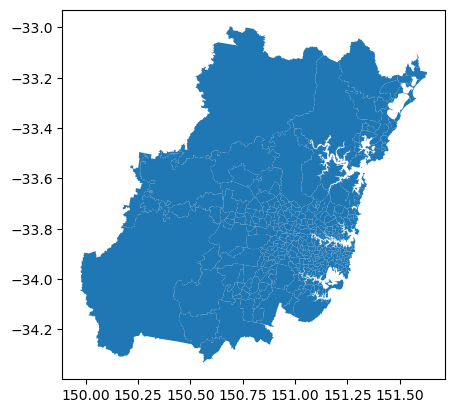

In [27]:
sa2_data.plot()
#plt.show()

<Axes: >

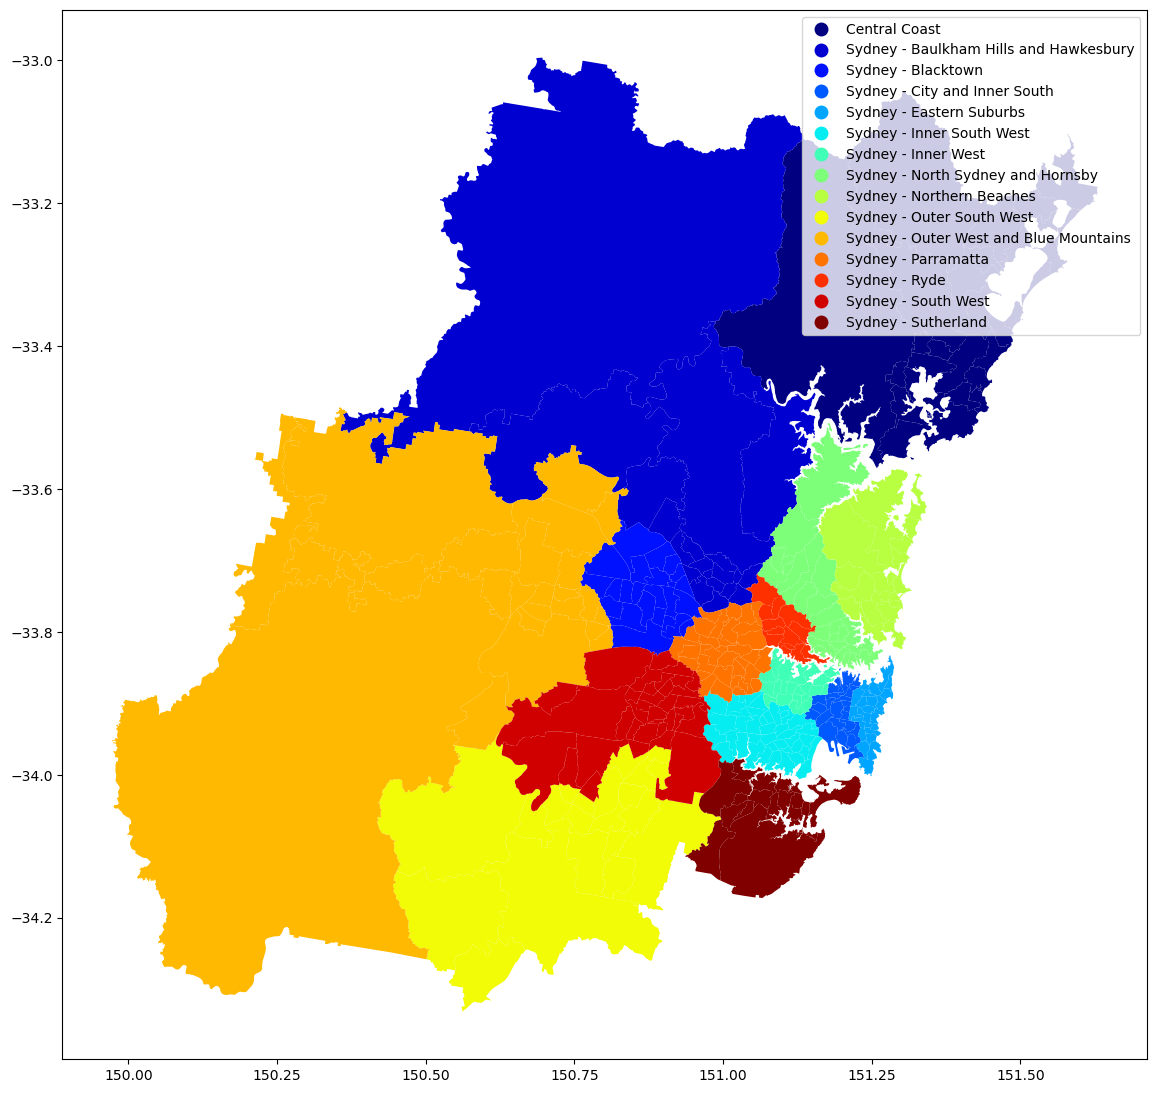

In [28]:
sa2_data.plot(column="sa4_name", categorical=True, legend=True, figsize=(14,16), cmap='jet')



In [29]:
reset()

Connected successfully.


In [51]:
def make_multipolygon(geom):
    if isinstance(geom, Polygon):
        return MultiPolygon([geom])
    return geom

sa2_data['geometry'] = sa2_data['geometry'].apply(make_multipolygon)
sa2_data.head()

,sa2_code,sa2_name,sa3_code,sa3_name,sa4_code,sa4_name,sq_km,geometry
28,102011028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,6.4376,"MULTIPOLYGON (((151.41373 -33.46558, 151.41362..."
29,102011029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,32.0802,"MULTIPOLYGON (((151.37484 -33.50052, 151.37507..."
30,102011030,Calga - Kulnura,10201,Gosford,102,Central Coast,767.9512,"MULTIPOLYGON (((151.20449 -33.5328, 151.20448 ..."
31,102011031,Erina - Green Point,10201,Gosford,102,Central Coast,33.7934,"MULTIPOLYGON (((151.37194 -33.43698, 151.37288..."
32,102011032,Gosford - Springfield,10201,Gosford,102,Central Coast,16.9123,"MULTIPOLYGON (((151.32349 -33.42779, 151.32342..."


In [52]:
sa2_data.to_crs(epsg=4283, inplace=True)
sa2_data.crs

<Geographic 2D CRS: EPSG:4283>
Name: GDA94
Axis Info [ellipsoidal]:
- Lat[north]: Geodetic latitude (degree)
- Lon[east]: Geodetic longitude (degree)
Area of Use:
- name: Australia including Lord Howe Island, Macquarie Island, Ashmore and Cartier Islands, Christmas Island, Cocos (Keeling) Islands, Norfolk Island. All onshore and offshore.
- bounds: (93.41, -60.55, 173.34, -8.47)
Datum: Geocentric Datum of Australia 1994
- Ellipsoid: GRS 1980
- Prime Meridian: Greenwich

In [55]:
#creating table in database
reset()
conn.execute(text("""
DROP TABLE IF EXISTS sa2;
CREATE TABLE sa2(
    sa2_code INTEGER PRIMARY KEY,
    sa2_name VARCHAR(50),
    sa3_code INTEGER,
    sa3_name VARCHAR(50),
    sa4_code INTEGER,
    sa4_name VARCHAR(50),
    sq_km DOUBLE PRECISION,
    geometry GEOMETRY(MULTIPOLYGON, 4283)
);"""))

Connected successfully.


In [57]:
sa2_data.to_postgis("sa2", con=conn, if_exists='append', index=False, dtype={"geometry": geoalchemy2.Geometry("MULTIPOLYGON", srid=4283)})
conn.commit()

InternalError: (psycopg2.errors.RaiseException) find_srid() - could not find the corresponding SRID - is the geometry registered in the GEOMETRY_COLUMNS table?  Is there an uppercase/lowercase mismatch?
CONTEXT:  PL/pgSQL function find_srid(character varying,character varying,character varying) line 17 at RAISE

[SQL: SELECT Find_SRID('public', 'sa2', 'geometry');]
(Background on this error at: https://sqlalche.me/e/20/2j85)

# Catchments (Schools)


# Schema

CREATE SCHEMA IF NOT EXISTS SA2;
SET search_path to SA2;

DROP TABLE IF EXISTS Income;
CREATE TABLE Income(
sa2_code INTEGER PRIMARY KEY,
sa2_name VARCHAR(50),
earners INTEGER,
median_age INTEGER,
median_income INTEGER,
mean_income INTEGER
);

DROP TABLE IF EXISTS 









DROP TABLE IF EXISTS Prices;
CREATE TABLE Prices(
Observation INTEGER,
Fuel VARCHAR(3),
Price NUMERIC,
PRIMARY KEY (Observation, Fuel)
);

DROP TABLE IF EXISTS Observations;
CREATE TABLE Observations(
ID INTEGER PRIMARY KEY,
Station VARCHAR(50),
ObservationDate DATE,
ObservationTime TIME
);

DROP TABLE IF EXISTS Stations;
CREATE TABLE Stations(
ID VARCHAR(50) PRIMARY KEY,
Name VARCHAR(100),
Address VARCHAR(100),
Suburb VARCHAR(50),
Postcode INTEGER,
Company VARCHAR(50)
);

DROP TABLE IF EXISTS Companies;
CREATE TABLE Companies(
ID VARCHAR(50) PRIMARY KEY,
Company VARCHAR(50),
Founded INTEGER,
HQ VARCHAR(50),
Source VARCHAR(100)
);

DROP TABLE IF EXISTS Fuel;
CREATE TABLE Fuel(
Code VARCHAR(3) PRIMARY KEY,
Name VARCHAR(50),
Base VARCHAR(50)
);
